In [1]:
import warnings
warnings.filterwarnings('ignore')

Preview of dataset:
                    id                                               text  \
0  1158315949990252544  @USER Love it keep up the good work sunshine b...   
1  1161787110359273472  Lmaooo y’all got other women telling y’all tha...   
2  1161808970727743488  @USER I feel that sis. They needa begin deacti...   
3  1186683819274801152  all "rivalry's" and shit talking aside im so h...   
4  1187391554757038081  Black musicians think they have to say a bunch...   

         T1 Target    T1 Argument T1 Harmful        T2 Target   T2 Argument  \
0            @USER    fuck em all         NO              NaN           NaN   
1            y'all  sounds stupid        YES              NaN           NaN   
2           niggas         niggas        YES           niggas  deactivating   
3              NaN   shit talking         NO              NaN           NaN   
4  Black musicians      homo shit        YES  Black musicians           sad   

  T2 Harmful T3 Target T3 Argument T3 Harm

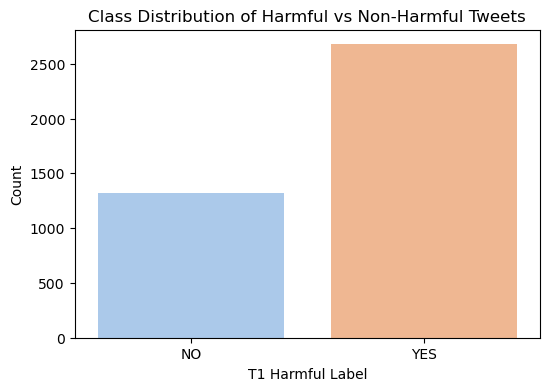

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset
file_path = "TBO_4k_train.xlsx"  
df = pd.read_excel(file_path)

# Displaying the first few rows
print("Preview of dataset:")
print(df.head())

# Checking the basic info
print("\nDataset Info:")
print(df.info())

# Checking for the missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Checking for the unique values in target column
print("\nUnique values in T1 Harmful column:")
print(df['T1 Harmful'].value_counts())

# Calculating the class distribution
label_counts = df['T1 Harmful'].value_counts()
label_percent = df['T1 Harmful'].value_counts(normalize=True) * 100
print("\nClass Distribution (count and %):")
print(pd.concat([label_counts, label_percent], axis=1, keys=['Count', 'Percent']))

# Visualizing the class imbalance
plt.figure(figsize=(6,4))
sns.countplot(x='T1 Harmful', data=df, palette='pastel')
plt.title('Class Distribution of Harmful vs Non-Harmful Tweets')
plt.xlabel('T1 Harmful Label')
plt.ylabel('Count')
plt.show()


In [3]:
import pandas as pd

# Keepping only the relevant columns
df = df[['id', 'text', 'T1 Harmful']]

# Mapping the target labels to numeric values
df['label'] = df['T1 Harmful'].map({'YES': 1, 'NO': 0})

# Dropping the rows with missing text or label 
df = df.dropna(subset=['text', 'label'])

# Dropping the duplicates
df = df.drop_duplicates(subset='text')

# Checking the cleaned structure
print("Cleaned dataset shape:", df.shape)
print("\nClass distribution after cleaning:")
print(df['label'].value_counts())

print("\nPreview of cleaned data:")
print(df.head())


Cleaned dataset shape: (3998, 4)

Class distribution after cleaning:
label
1    2677
0    1321
Name: count, dtype: int64

Preview of cleaned data:
                    id                                               text  \
0  1158315949990252544  @USER Love it keep up the good work sunshine b...   
1  1161787110359273472  Lmaooo y’all got other women telling y’all tha...   
2  1161808970727743488  @USER I feel that sis. They needa begin deacti...   
3  1186683819274801152  all "rivalry's" and shit talking aside im so h...   
4  1187391554757038081  Black musicians think they have to say a bunch...   

  T1 Harmful  label  
0         NO      0  
1        YES      1  
2        YES      1  
3         NO      0  
4        YES      1  


In [4]:
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# --- TEXT CLEANING FUNCTION ---
def clean_text(text):
    text = text.lower()  # converting the text to lowercase
    text = re.sub(r'@[\w]+', '', text)  # removes all the mentions like @user
    text = re.sub(r'http\S+|www\S+', '', text)  # removes the URLs
    text = re.sub(r'#\w+', '', text)  # removes the hashtags
    text = re.sub(r'[^a-z\s]', '', text)  # removes the non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # removes the extra spaces
    return text

# Applying the text cleaning
df['clean_text'] = df['text'].apply(clean_text)

# --- TRAIN TEST SPLIT (Stratified) ---
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("\nLabel distribution in training set:")
print(y_train.value_counts(normalize=True))

# --- HANDLING THE CLASS IMBALANCE BY USING CLASS WEIGHTS ---
classes = np.array([0, 1])  # must be a NumPy array
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

print("\nComputed Class Weights:")
print(class_weights)

print("\nSample cleaned tweet text:")
print(df['clean_text'].head(5))


Train size: 3198
Test size: 800

Label distribution in training set:
label
1    0.669481
0    0.330519
Name: proportion, dtype: float64

Computed Class Weights:
{np.int64(0): np.float64(1.512771996215705), np.int64(1): np.float64(0.7468472676319476)}

Sample cleaned tweet text:
0    love it keep up the good work sunshine big or ...
1    lmaooo yall got other women telling yall that ...
2    i feel that sis they needa begin deactivating ...
3    all rivalrys and shit talking aside im so happ...
4    black musicians think they have to say a bunch...
Name: clean_text, dtype: object


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- TF-IDF VECTORIZATION ---
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF feature matrix shape (train):", X_train_tfidf.shape)

# --- TRAINING THE LOGISTIC REGRESSION MODEL ---
lr_model = LogisticRegression(class_weight=class_weights, max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# --- PREDICTING ---
y_pred = lr_model.predict(X_test_tfidf)

TF-IDF feature matrix shape (train): (3198, 5000)



Model Performance on Test Set:
Accuracy: 0.70875

Classification Report:
              precision    recall  f1-score   support

 Not Harmful       0.55      0.71      0.62       264
     Harmful       0.83      0.71      0.77       536

    accuracy                           0.71       800
   macro avg       0.69      0.71      0.69       800
weighted avg       0.74      0.71      0.72       800



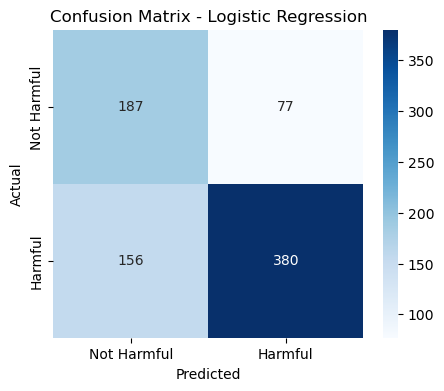

In [6]:
# --- EVALUATING ---
print("\nModel Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Harmful', 'Harmful']))

# --- CONFUSION MATRIX ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Harmful','Harmful'], yticklabels=['Not Harmful','Harmful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- TRAINING THE RANDOM FOREST MODEL ---
rf_model = RandomForestClassifier(
    n_estimators=200,              # number of trees
    class_weight='balanced',       # handling the imbalance
    random_state=42,
    max_depth=None,                # let the trees expand fully
    n_jobs=-1                      # using all the CPU cores
)

rf_model.fit(X_train_tfidf, y_train)

# --- PREDICTING ---
y_pred_rf = rf_model.predict(X_test_tfidf)


Random Forest Model Performance on Test Set:
Accuracy: 0.7225

Classification Report:
              precision    recall  f1-score   support

 Not Harmful       0.58      0.57      0.58       264
     Harmful       0.79      0.80      0.79       536

    accuracy                           0.72       800
   macro avg       0.69      0.68      0.69       800
weighted avg       0.72      0.72      0.72       800



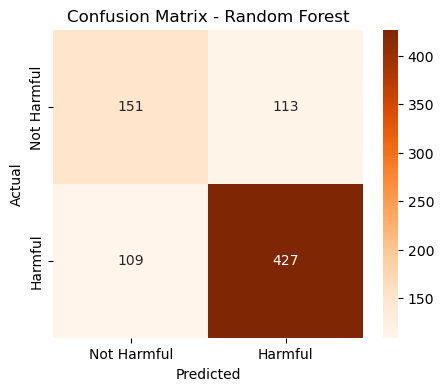

In [8]:
# --- EVALUATNG ---
print("\nRandom Forest Model Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Not Harmful', 'Harmful']))

# --- CONFUSION MATRIX ---
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Not Harmful','Harmful'],
            yticklabels=['Not Harmful','Harmful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Defining the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initializing the base model
rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Grid search with the 5 fold CV
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train_tfidf, y_train)

# Best parameters and the score
print("Best Parameters Found:")
print(grid_rf.best_params_)
print("\nBest Cross-Validated F1 Score: {:.4f}".format(grid_rf.best_score_))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters Found:
{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best Cross-Validated F1 Score: 0.7261



Tuned Random Forest Performance on Test Set:
Accuracy: 0.71125

Classification Report:
              precision    recall  f1-score   support

 Not Harmful       0.55      0.70      0.61       264
     Harmful       0.83      0.72      0.77       536

    accuracy                           0.71       800
   macro avg       0.69      0.71      0.69       800
weighted avg       0.74      0.71      0.72       800



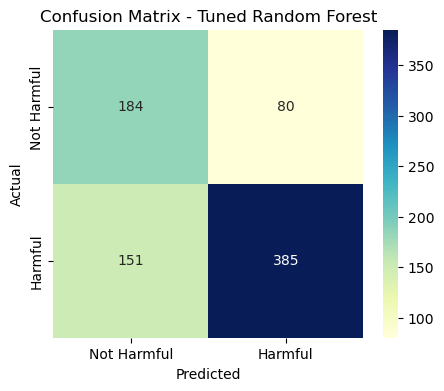

In [10]:

# Evaluating the tuned model
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_tfidf)

print("\nTuned Random Forest Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_rf, target_names=['Not Harmful', 'Harmful']))

# Confusion Matrix
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_best_rf, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Not Harmful','Harmful'],
            yticklabels=['Not Harmful','Harmful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.show()